### Yonatan Klausner, Jonathan Rawson, and Yair Fax 
## Final Project 

In [44]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(14, 7)

# hustle stat - average mph, miles run, balls deflected, contested shots, stats per minute (steals, o rebounds, feet), 
# jump balls, Loose balls recovered, boxouts, screen assists, charges, team, average salary, all nba or all star teams 
# https://stats.nba.com/players/speed-distance/?sort=AVG_SPEED&dir=1

# To do:
# 1) change the way calculate hustle score 
#        a) per minute 
#        b) add in distance and speed (https://stats.nba.com/players/speed-distance/?sort=DIST_MILES_DEF&dir=1&Season=2017-18&SeasonType=Regular%20Season)
#        c) standardize or not needed?
# 2) change up scatter plots 
# 3) multiple webdrivers at once? possible? good idea?
# 4) sort by position
# 5) trends over time - playoff teams, non-playoff teams, championship teams
# 6) predict current season outcomes
# 7) more detailed comparisons with wins
# 8) look at specific player hustle in a team as correlated with wins
# 9) ML 

# GP >= 40 make sure not for current season


## Part 1: Get Data

### Step 1: Define Functions for Getting Different Data

In [72]:
def getHustleStats(year):
    return getYearStats("https://stats.nba.com/players/hustle/?sort=MIN&dir=-1&Season=" + year + "&SeasonType=Regular%20Season", year)

def getRegularStats(year):
    return getYearStats("https://stats.nba.com/leaders/?Season=" + year + "&SeasonType=Regular%20Season", year)

def getYearStats(url, year):
    # Use an automated browser so that the webpage is rendered properly
    browser = webdriver.Safari()
    browser.get(url)
    
    # Edit HTML so that we can get the whole table
    browser.execute_script('document.getElementsByClassName("stats-table-pagination__select")[0].setAttribute("id", "btn")')
    browser.execute_script('document.getElementById("btn").children[0].setAttribute("id", "select-all")')
    nextButton = browser.find_element_by_id('btn')
    allButton = browser.find_element_by_id('select-all')
    
    # Click on buttons to get whole table
    nextButton.click()
    allButton.click()
    
    # Get HTML and parse
    innerHTML = browser.execute_script("return document.body.innerHTML")
    root = BeautifulSoup(innerHTML, "lxml")
    table = pd.read_html(str(root.find("table")))
    table = table[0]
    
    # Add year column for later table merging
    table['year'] = year
    browser.close()
    return table

def getPositions(year):
    url = "https://www.basketball-reference.com/leagues/NBA_" + str(year) + "_per_game.html"
    r = requests.get(url)
    root = BeautifulSoup(r.content, "lxml")
    data = root.find("table")
    positions_table = pd.read_html(str(data))[0]
    positions_table['year'] = str(year - 1) + "-" + str(year - 2000)
    return positions_table

def getTeams(filename, year):
    teamTable = pd.read_csv(filename)
    teamTable['year'] = year
    return teamTable

def stripChars(series):
    return series.str.replace('.', '').str.replace('Jr', '').str.replace(',', '').str.replace('III', '').str.replace('II', '').str.replace('IV', '').str.rstrip()

### Step 2: Get Hustle Data on Players

In [4]:
hustle16_17 = getHustleStats("2016-17")
hustle17_18 = getHustleStats("2017-18")
regular16_17 = getRegularStats("2016-17")
regular17_18 = getRegularStats("2017-18")

In [73]:
hustleStats = hustle16_17.append(hustle17_18)
hustleStats['Player'] = stripChars(hustleStats['Player'])
hustleStats.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year
0,Danuel House,WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17


### Step 3: Get Data for Regular Statistics on Players (i.e. GP, MIN, PTS, FG%, etc.)

In [74]:
regularStats = regular16_17.append(regular17_18)
regularStats.head()

,#,Player,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,year
0,1,Russell Westbrook,81,34.6,31.6,10.2,24.0,42.5,2.5,7.2,...,84.5,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17
1,2,James Harden,81,36.4,29.1,8.3,18.9,44.0,3.2,9.3,...,84.7,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17
2,3,Isaiah Thomas,76,33.8,28.9,9.0,19.4,46.3,3.2,8.5,...,90.9,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17
3,4,Anthony Davis,75,36.1,28.0,10.3,20.3,50.5,0.5,1.8,...,80.2,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17
4,5,DeMar DeRozan,74,35.4,27.3,9.7,20.9,46.7,0.4,1.7,...,84.2,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17


### Step 4: Get Data for Positions of Players

In [75]:
positions16_17 = getPositions(2017)[['Player', 'Pos', 'year']]
positions17_18 = getPositions(2018)[['Player', 'Pos', 'year']]

In [76]:
positions = positions16_17.append(positions17_18)
positions['Player'] = stripChars(positions['Player'])

### Step 5: Get Data for Team Wins 

In [77]:
teamsWins16_17 = getTeams('teams_2016_2017.csv', '2016-17') # http://media.nba.com/Stats/Standings.aspx?&leagueid=00&seasonid=22016
teamsWins17_18 = getTeams('teams_2017_2018.csv', '2017-18') # http://media.nba.com/Stats/Standings.aspx?&leagueid=00&seasonid=22017
teamsWins16_17.head()

,Team,W,L,Win%,GB,Conf,Div,Home,Road,OT,Last 10,Streak,year
0,BOS,53,29,0.646,0,36-16,11-5,30-11,23-18,2-1,7-3,W 3,2016-17
1,CLE,51,31,0.622,2,35-17,8-8,31-10,20-21,3-4,4-6,L 4,2016-17
2,TOR,51,31,0.622,2,34-18,14-2,28-13,23-18,3-1,8-2,W 4,2016-17
3,WAS,49,33,0.598,4,32-20,8-8,30-11,19-22,4-3,5-5,L 1,2016-17
4,ATL,43,39,0.524,10,30-22,6-10,23-18,20-21,5-0,6-4,L 1,2016-17


## Part 2: Clean Data

In [78]:
hustleStatsTemp = pd.merge(hustleStats, positions, on=['Player', 'year'], how='left')
hustleStatsTemp[pd.isnull(hustleStatsTemp['Pos'])]

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
158,Juancho Hernangomez,DEN,21,62,13.6,0.3,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.00,3.1,1.7,4.7,2016-17,NaN
244,Taurean Prince,ATL,23,59,16.6,0.1,0.2,1.4,0.0,0.0,0.6,0.0,0.0,0.05,2.9,2.4,5.2,2016-17,NaN
275,Nene,HOU,34,67,17.9,2.8,6.5,1.5,0.0,0.0,0.7,0.0,0.0,0.15,4.9,1.7,6.6,2016-17,NaN
601,Vincent Hunter,MEM,23,4,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.5,1.0,2017-18,NaN
669,Walter Lemon,NOP,25,5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.4,0.2,1.6,2017-18,NaN
745,Juancho Hernangomez,DEN,22,25,11.1,0.2,0.4,0.5,0.2,0.2,0.3,50.0,50.0,0.04,2.3,1.5,3.8,2017-18,NaN
840,Nene,HOU,35,52,14.6,2.0,4.9,1.4,0.1,0.3,0.5,25.0,75.0,0.04,3.5,1.9,5.4,2017-18,NaN
882,Wes Iwundu,ORL,23,62,16.5,0.1,0.2,0.8,0.1,0.3,0.5,30.0,70.0,0.05,1.8,1.7,3.5,2017-18,NaN
1162,Taurean Prince,ATL,24,82,30.0,0.2,0.5,1.8,0.5,0.6,1.1,43.3,56.7,0.11,3.8,2.8,6.6,2017-18,NaN


In [79]:
positions.loc[positions['Player'] == 'Nene Hilario', 'Player'] = 'Nene'
positions.loc[positions['Player'] == 'Taurean Waller-Prince', 'Player'] = 'Taurean Prince'
hustleStats = pd.merge(hustleStats, positions, on=['Player', 'year'], how='left')
hustleStats[pd.isnull(hustleStats['Pos'])]

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
158,Juancho Hernangomez,DEN,21,62,13.6,0.3,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.00,3.1,1.7,4.7,2016-17,NaN
601,Vincent Hunter,MEM,23,4,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.5,1.0,2017-18,NaN
669,Walter Lemon,NOP,25,5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.4,0.2,1.6,2017-18,NaN
745,Juancho Hernangomez,DEN,22,25,11.1,0.2,0.4,0.5,0.2,0.2,0.3,50.0,50.0,0.04,2.3,1.5,3.8,2017-18,NaN
882,Wes Iwundu,ORL,23,62,16.5,0.1,0.2,0.8,0.1,0.3,0.5,30.0,70.0,0.05,1.8,1.7,3.5,2017-18,NaN


In [80]:
hustleStats = hustleStats.dropna(subset=['Pos'])
hustleStats.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
0,Danuel House,WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17,SG
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17,PG
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17,C
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17,PF
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17,PF


Cleaning the table: First, we delete any players who do not average 15 minutes per game.  Then we drop columns that we will not be using. 

In [81]:
hustleStats = hustleStats[hustleStats['MIN'] >= 15] # Delete players who did not average 15 minutes per game 
hustleStats = hustleStats[hustleStats['GP'] >= 40] # Delete players who did not play 40 games 
hustleStats = hustleStats.rename({'TEAM': 'Team'}, axis=1) # Rename column 
# Drop unused columns 
hustleStats = hustleStats.drop(['ScreenAssists PTS', 'OFF Loose BallsRecovered', 'DEF Loose BallsRecovered', '% Loose BallsRecovered OFF', '% Loose BallsRecovered DEF'], axis=1)
hustleStats = hustleStats.drop_duplicates(subset=['Player', 'year'])
hustleStats.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
199,Alan Williams,PHX,24,47,15.1,2.1,1.0,0.6,0.00,5.7,0.9,6.6,2016-17,C
200,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17,SG
203,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17,PG
205,Alec Burks,UTA,25,42,15.5,0.1,0.8,0.4,0.00,1.6,1.4,3.0,2016-17,SG
206,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17,SG


In [82]:
teamWinsTable = teamsWins16_17.append(teamsWins17_18)
# Drop unused columns 
teamWinsTable = teamWinsTable.drop(['L', 'Win%', 'GB', 'Conf', 'Div', 'Home', 'Road', 'OT', 'Last 10', 'Streak'], axis=1)
teamWinsTable = teamWinsTable.rename({'W': 'Wins'}, axis=1) # Rename column
teamWinsTable.head()

,Team,Wins,year
0,BOS,53,2016-17
1,CLE,51,2016-17
2,TOR,51,2016-17
3,WAS,49,2016-17
4,ATL,43,2016-17


Now, we have 4 clean tables:   
hustleStats -   
regularStats -   
positions -   
teamsWinsTable -   

## Part 3: Calculate Hustle Score

In order to calculate our hustle score, we will use the sum of screen assists, deflections, loose balls recovered, charges drawn, and contested shots.  However, if we just took the sum of those statistics for each player, certain statistics, such as contested shots, would effect the overall hustle score more than others because its numbers are generally higher.  Therefore, we decided to normalize each statistic by dividing its value by the max for that specific statistic.  

In [83]:
maxScreenAssists = (hustleStats['ScreenAssists']/hustleStats['MIN']).max()
maxDeflections = (hustleStats['Deflections']/hustleStats['MIN']).max()
maxLooseBallsRecovered = (hustleStats['Loose BallsRecovered']/hustleStats['MIN']).max()
maxChargesDrawn = (hustleStats['ChargesDrawn']/hustleStats['MIN']).max()
maxContestedShots = (hustleStats['ContestedShots']/hustleStats['MIN']).max()
print("maxScreenAssists per minute: " + str(maxScreenAssists))
print("maxDeflections per minute: " + str(maxDeflections))
print("maxLooseBallsRecovered per minute: " + str(maxLooseBallsRecovered))
print("maxChargesDrawn per minute: " + str(maxChargesDrawn))
print("maxContestedShots per minute: " + str(maxContestedShots))

maxScreenAssists per minute: 0.21223021582733814
maxDeflections per minute: 0.13291139240506328
maxLooseBallsRecovered per minute: 0.06046511627906977
maxChargesDrawn per minute: 0.026114649681528664
maxContestedShots per minute: 0.5750000000000001


In [84]:
hustleStats['HustleScore'] = (hustleStats['ScreenAssists']/maxScreenAssists + hustleStats['Deflections']/maxDeflections + hustleStats['Loose BallsRecovered']/maxLooseBallsRecovered + hustleStats['ChargesDrawn']/maxChargesDrawn + hustleStats['ContestedShots']/maxContestedShots)/(hustleStats['MIN'])
hustleStats.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,HustleScore
199,Alan Williams,PHX,24,47,15.1,2.1,1.0,0.6,0.00,5.7,0.9,6.6,2016-17,C,2.570865
200,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17,SG,1.561242
203,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17,PG,1.281575
205,Alec Burks,UTA,25,42,15.5,0.1,0.8,0.4,0.00,1.6,1.4,3.0,2016-17,SG,1.182130
206,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17,SG,1.246396


In [85]:
# Sort table by HustleScore
hustleStats = hustleStats.sort_values(by=['HustleScore'],ascending=False)
hustleStats.head(5)

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,HustleScore
334,Nerlens Noel,DAL,23,51,20.5,2.2,2.7,0.9,0.04,7.0,1.5,8.5,2016-17,C,3.018503
278,Zaza Pachulia,GSW,33,70,18.1,3.5,1.8,0.8,0.00,5.5,0.8,6.3,2016-17,C,2.995673
275,Nene,HOU,34,67,17.9,2.8,1.5,0.7,0.15,4.9,1.7,6.6,2016-17,C,2.976426
901,Gorgui Dieng,MIN,28,79,16.9,1.7,1.3,0.8,0.18,4.9,1.8,6.7,2017-18,C,2.932944
304,Lucas Nogueira,TOR,24,57,19.1,3.7,1.6,0.5,0.00,8.3,1.9,10.2,2016-17,C,2.904731


## Part 4: Look for Potential Correlation Between HustleScore and Other Parameters

Text(0, 0.5, 'Hustle Scores')

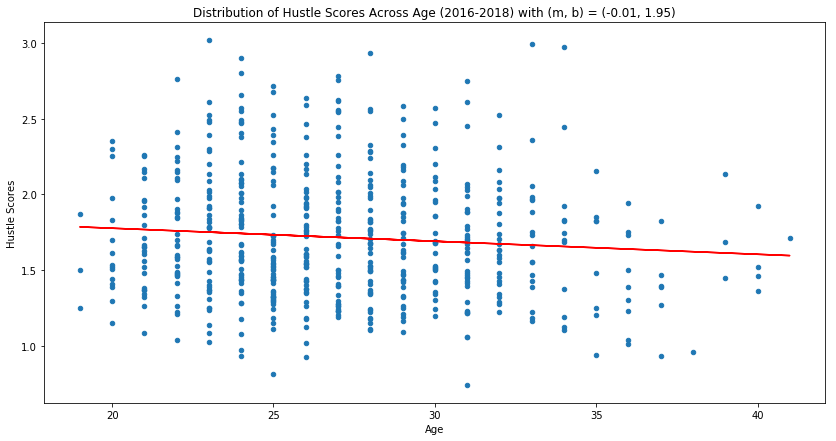

In [86]:
scatter = hustleStats.plot.scatter('AGE', 'HustleScore')

(m, b) = np.polyfit(hustleStats['AGE'], hustleStats['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in hustleStats['AGE']]
scatter.plot(hustleStats['AGE'], regression_line, color='red') 

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Age (2016-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Age")
scatter.set_ylabel("Hustle Scores")

Text(0, 0.5, 'Hustle Scores')

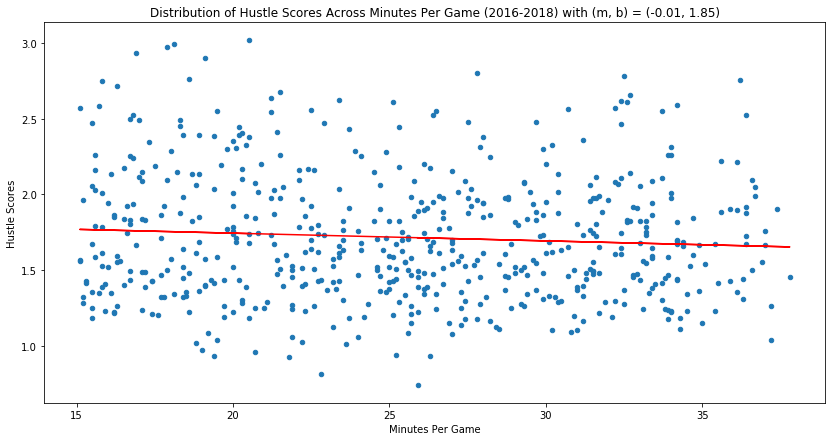

In [87]:
scatter = hustleStats.plot.scatter('MIN', 'HustleScore')

(m, b) = np.polyfit(hustleStats['MIN'], hustleStats['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in hustleStats['MIN']]
scatter.plot(hustleStats['MIN'], regression_line, color='red') 

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Minutes Per Game (2016-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Minutes Per Game")
scatter.set_ylabel("Hustle Scores")

In [88]:
teamHustleTable = pd.DataFrame(hustleStats.groupby(['Team', 'year'])['HustleScore'].sum())
teamHustleTable = teamHustleTable.sort_values(by=['HustleScore'],ascending=False)
teamHustleTable = teamHustleTable.reset_index()
teamHustleTable.head()

,Team,year,HustleScore
0,PHI,2017-18,21.012343
1,TOR,2016-17,20.201726
2,TOR,2017-18,19.966247
3,ATL,2016-17,19.921226
4,HOU,2016-17,19.311220


In [89]:
teamTable = pd.merge(teamHustleTable, teamWinsTable, on=['Team', 'year'])
teamTable.head()

,Team,year,HustleScore,Wins
0,PHI,2017-18,21.012343,52
1,TOR,2016-17,20.201726,51
2,TOR,2017-18,19.966247,59
3,ATL,2016-17,19.921226,43
4,HOU,2016-17,19.311220,55


Text(0.5, 1.0, 'Distribution of Hustle Scores Across Team Wins (2016-2018) with (m, b) = (0.93, 25.59)')

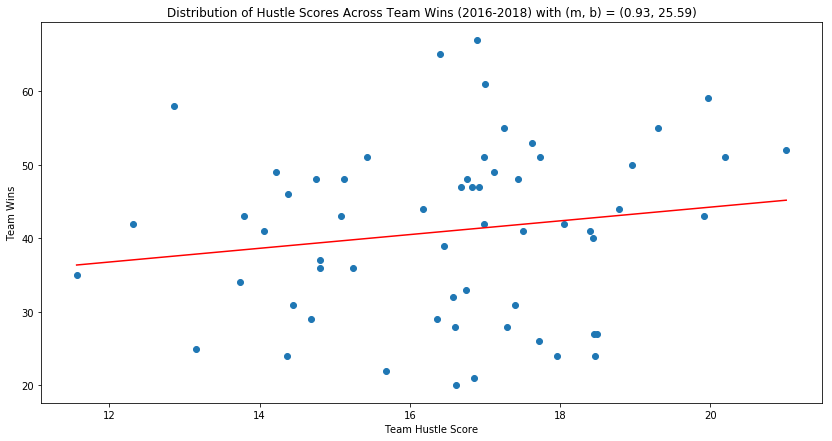

In [90]:
teamTable['Wins'] = teamTable['Wins'].astype('int32')
x = teamTable['HustleScore']
y = teamTable['Wins']
fig, ax = plt.subplots()
ax.scatter(x, y) # try to switch x and y here
ax.set_xlabel("Team Hustle Score")
ax.set_ylabel("Team Wins")

(m, b) = np.polyfit(teamTable['HustleScore'], teamTable['Wins'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in teamTable['HustleScore']]
ax.plot(teamTable['HustleScore'], regression_line, color='red') 
ax.set_title("Distribution of Hustle Scores Across Team Wins (2016-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")




# (m, b) = np.polyfit(teamTable['HustleScore'], teamTable['Wins'], 1)
# # Calculate the actual best fit line 
# regression_line = [(m*x)+b for x in teamTable['HustleScore']]
# scatter.plot(teamTable['HustleScore'], regression_line, color='red') 

# # Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Team Wins (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
# ax.set_xlabel("Team Hustle Score")
# ax.set_ylabel("Team Wins")

# scatter = teamTable.plot.scatter('Wins', 'HustleScore')
# # Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Team Wins (2017-2018)")
# scatter.set_xlabel("Team Wins")
# scatter.set_ylabel("Team Hustle Score")

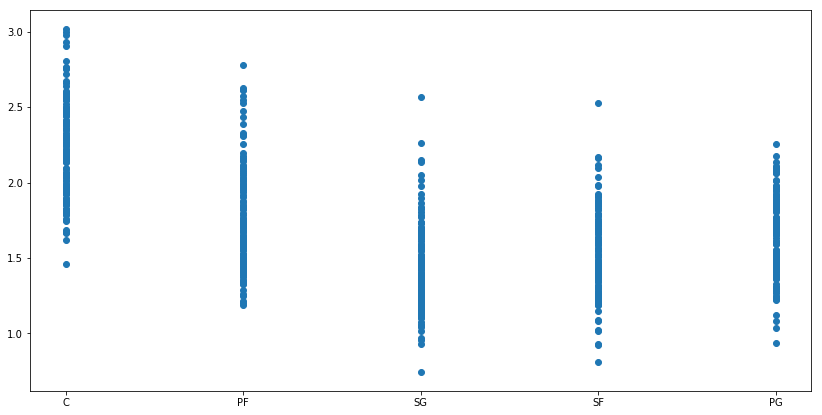

In [91]:
# TODO: Explain this line
hustleStats.loc[hustleStats['Pos'] == 'SF-SG', 'Pos'] = 'SF'
x = hustleStats['Pos']
y = hustleStats['HustleScore']
fig, ax = plt.subplots()
ax.scatter(x, y)


# # TODO: Explain this line
# hustleStats.loc[hustleStats['Pos'] == "SF-SG", 'Pos'] = "SF"
# #x = hustleStats['Pos']
# y = hustleStats['HustleScore']
# fig, ax = plt.subplots()
# x = list(range(hustleStats['HustleScore'].size))
# xTicks = ['C','PF', 'SF', 'SG', 'PG']
# # ax.xticks(x, xTicks)
# # ax.scatter([x], y)


# pl.xticks(x, xTicks)
# pl.xticks(range(2), xTicks, rotation=45) #writes strings with 45 degree angle
# pl.plot(x,y)
# pl.show()

In [92]:
topTeams = teamTable[teamTable['Wins'] >= teamTable['Wins'].median()]
topTeams = topTeams[topTeams['HustleScore'] >= topTeams['HustleScore'].median()]
topTeams.head()

,Team,year,HustleScore,Wins
0,PHI,2017-18,21.012343,52
1,TOR,2016-17,20.201726,51
2,TOR,2017-18,19.966247,59
3,ATL,2016-17,19.921226,43
4,HOU,2016-17,19.311220,55


In [93]:
bottomTeams = teamTable[teamTable['Wins'] < teamTable['Wins'].median()]
bottomTeams = bottomTeams[bottomTeams['HustleScore'] < bottomTeams['HustleScore'].median()]
bottomTeams.head()

,Team,year,HustleScore,Wins
35,SAC,2016-17,16.569809,32
36,DET,2017-18,16.461530,39
38,NYK,2017-18,16.363151,29
40,MEM,2017-18,15.687418,22
42,CHA,2017-18,15.243277,36


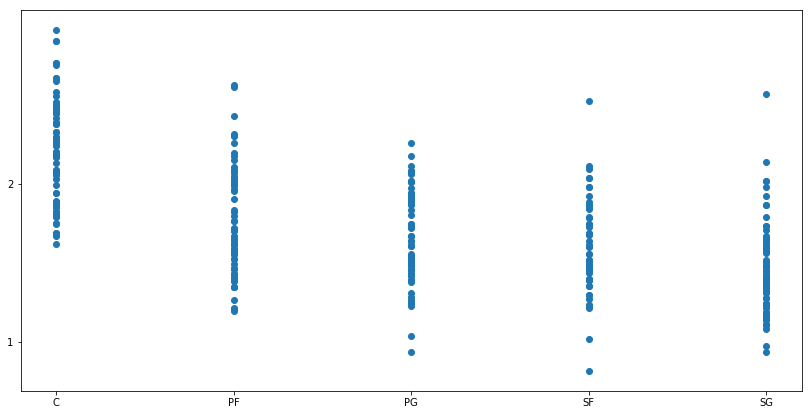

In [94]:
topTeamsPlayers = pd.merge(topTeams, hustleStats, how='left', on=['Team']).sort_values('Pos')
x = topTeamsPlayers['Pos']
y = topTeamsPlayers['HustleScore_y']
fig, ax = plt.subplots()
ax.set_yticks(range(1,3,1))
ax.scatter(x, y)

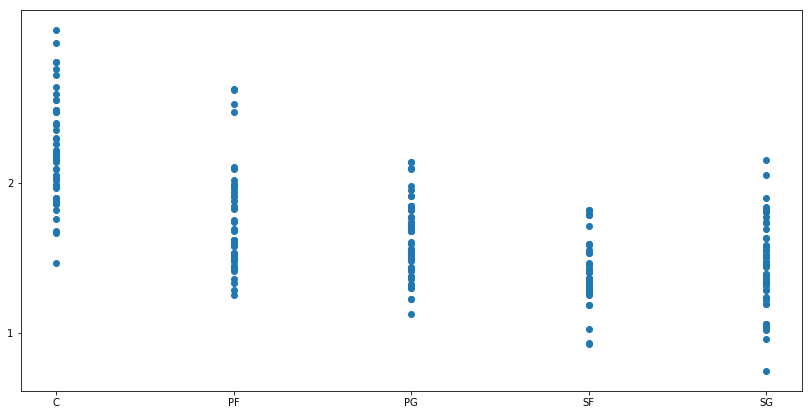

In [95]:
bottomTeamsPlayers = pd.merge(bottomTeams, hustleStats, how='left', on=['Team']).sort_values('Pos')
x = bottomTeamsPlayers['Pos']
y = bottomTeamsPlayers['HustleScore_y']
fig, ax = plt.subplots()
ax.set_yticks(range(1,3,1))
ax.scatter(x, y) 

## Part 5: Learning a Better Hustle Score
We used heuristics to try and guess at a good hustle score that would have meaning, now we try to learn a better hustle score.

In [172]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [173]:
# Get points for each player in hustle stats table
hustleStatsWithPTS = hustleStats.merge(regularStats[['Player', 'PTS', 'year']], on=['Player', 'year'], how='left')
hustleStatsWithPTS = hustleStatsWithPTS.dropna()
hustleStatsWithPTS = hustleStatsWithPTS.sort_values(by=['year', 'PTS'], ascending=False)
hustleStatsWithPTS.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos,HustleScore,PTS
282,James Harden,HOU,28,72,35.4,0.3,2.9,1.3,0.03,4.4,3.1,7.6,2017-18,SG,1.669457,30.4
29,Anthony Davis,NOP,25,75,36.4,3.9,2.4,1.5,0.15,9.8,4.5,14.3,2017-18,PF,2.523477,28.1
341,LeBron James,CLE,33,82,36.9,1.0,2.2,1.1,0.15,4.0,3.0,7.0,2017-18,PF,1.554861,27.5
133,Giannis Antetokounmpo,MIL,23,75,36.7,1.4,2.5,1.8,0.00,6.6,3.7,10.3,2017-18,PF,1.991510,26.9
369,Damian Lillard,POR,27,73,36.6,0.2,1.8,1.7,0.11,2.8,1.9,4.7,2017-18,PG,1.502369,26.9


In [98]:
reg = LinearRegression()
reg = reg.fit(hustleStatsWithPTS[['ScreenAssists', 'Deflections', 'Loose BallsRecovered', 'ChargesDrawn', 'ContestedShots']], hustleStatsWithPTS['PTS'])

In [99]:
hustleStatsWithPTS['residuals'] = hustleStatsWithPTS['PTS'] - reg.predict(hustleStatsWithPTS[['ScreenAssists', 'Deflections', 'Loose BallsRecovered', 'ChargesDrawn', 'ContestedShots']])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Team
ATL    -8.481225
BKN   -20.140791
BOS     2.776032
CHA     8.955455
CHI    -3.029759
CLE    41.378017
DAL    -2.267449
DEN     9.224718
DET    -0.773385
GSW     6.887019
HOU     4.547349
IND   -13.531443
LAC    23.492730
LAL     0.287193
MEM     0.959571
MIA   -16.543066
MIL    -8.550120
MIN   -15.643064
NOP    -2.820226
NYK     2.249346
OKC    -6.726088
ORL    -1.174907
PHI    -7.872746
PHX    -2.243416
POR    -3.036607
SAC   -16.367915
SAS    -0.046111
TOR     7.706584
UTA     8.106899
WAS    12.677403
Name: residuals, dtype: float64

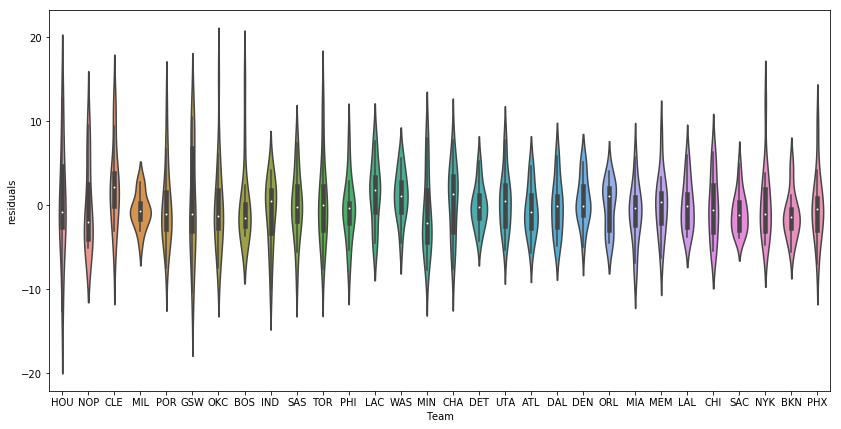

In [100]:
violin = sns.violinplot(x="Team", y="residuals", data=hustleStatsWithPTS)
hustleStatsWithPTS.groupby(['Team'])['residuals'].sum()

In [ ]:
hustleStatsWithPTS['interaction'] = hustleStatsWithPTS['ScreenAssists'] * hustleStatsWithPTS['Deflections'] * hustleStatsWithPTS['Loose BallsRecovered'] * hustleStatsWithPTS['ChargesDrawn'] * hustleStatsWithPTS['ContestedShots']
hustleStatsWithPTS.head()

In [ ]:
interactionReg = LinearRegression()
interactionReg = interactionReg.fit(hustleStatsWithPTS[['ScreenAssists', 'Deflections', 'Loose BallsRecovered', 'ChargesDrawn', 'ContestedShots', 'interaction']], hustleStatsWithPTS['PTS'])

In [ ]:
hustleStatsWithPTS['interactionResiduals'] = hustleStatsWithPTS['PTS'] - interactionReg.predict(hustleStatsWithPTS[['ScreenAssists', 'Deflections', 'Loose BallsRecovered', 'ChargesDrawn', 'ContestedShots', 'interaction']])

In [ ]:
violin = sns.violinplot(x="Team", y="interactionResiduals", data=hustleStatsWithPTS)

In [105]:
hustleReg = LinearRegression()
hustleReg.fit(hustleStatsWithPTS[['HustleScore']],hustleStatsWithPTS['PTS'])
hustleStatsWithPTS['hustleResidual'] = hustleStatsWithPTS['PTS'] - hustleReg.predict(hustleStatsWithPTS[['HustleScore']])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


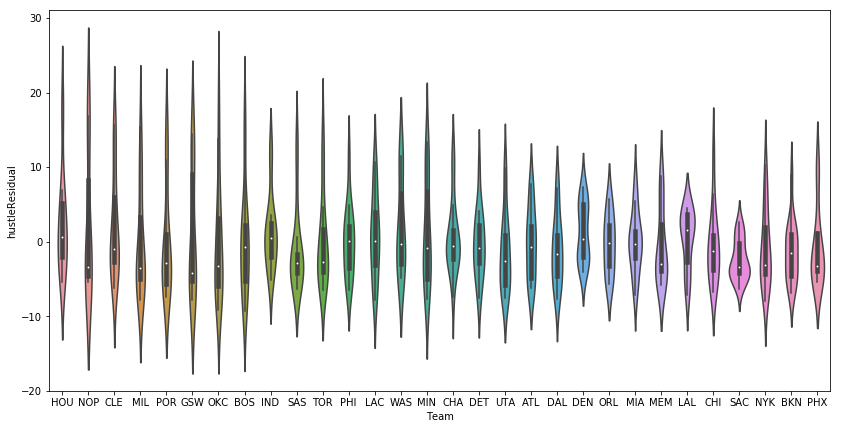

In [106]:
violin = sns.violinplot(x="Team", y="hustleResidual", data=hustleStatsWithPTS)

In [107]:
allStats = hustleStats.merge(regularStats, on=['Player', 'year', 'GP', 'MIN'], how='left')
allStats = allStats.dropna()
allStats.head()

,Player,Team,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF
1,Zaza Pachulia,GSW,33,70,18.1,3.5,1.8,0.8,0.00,5.5,...,1.8,77.8,2.0,3.9,5.9,1.9,0.8,0.5,1.2,11.5
2,Nene,HOU,34,67,17.9,2.8,1.5,0.7,0.15,4.9,...,2.9,58.9,1.4,2.8,4.2,1.0,0.8,0.6,1.1,11.1
3,Gorgui Dieng,MIN,28,79,16.9,1.7,1.3,0.8,0.18,4.9,...,1.3,77.5,1.3,3.2,4.6,0.9,0.6,0.5,0.7,8.9
5,Cody Zeller,CHA,24,62,27.8,5.9,2.0,1.1,0.03,7.9,...,3.2,67.9,2.2,4.4,6.5,1.6,1.0,0.9,1.0,15.2
6,Draymond Green,GSW,27,76,32.5,2.3,3.9,1.2,0.17,9.6,...,2.8,70.9,1.3,6.6,7.9,7.0,2.0,1.4,2.4,20.3


In [121]:
regularStatsWithTeam = regularStats.merge(hustleStats[['Player', 'Team', 'year']], on=['Player', 'year']).drop(['#'], axis=1)
#regularStatsWithWins = regularStatsWithWins.groupby(['Team']).mean().merge(teamTable, on=['Team'])
regularStatsWithTeam = regularStatsWithTeam.drop(['GP', 'MIN'], axis=1)
regularStatsWithTeam.head()

,Player,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,year,Team
0,Russell Westbrook,31.6,10.2,24.0,42.5,2.5,7.2,34.3,8.8,10.4,...,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17,OKC
1,James Harden,29.1,8.3,18.9,44.0,3.2,9.3,34.7,9.2,10.9,...,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17,HOU
2,Isaiah Thomas,28.9,9.0,19.4,46.3,3.2,8.5,37.9,7.8,8.5,...,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17,BOS
3,Anthony Davis,28.0,10.3,20.3,50.5,0.5,1.8,29.9,6.9,8.6,...,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17,NOP
4,DeMar DeRozan,27.3,9.7,20.9,46.7,0.4,1.7,26.6,7.4,8.7,...,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17,TOR


In [124]:
print(regularStatsWithTeam.columns)
regularStatsWithTeam.head()

Index(['Player', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA',
       'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'EFF', 'year',
       'Team', 'residuals'],
      dtype='object')


,Player,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,DREB,REB,AST,STL,BLK,TOV,EFF,year,Team,residuals
0,Russell Westbrook,31.6,10.2,24.0,42.5,2.5,7.2,34.3,8.8,10.4,...,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17,OKC,-2.532363
1,James Harden,29.1,8.3,18.9,44.0,3.2,9.3,34.7,9.2,10.9,...,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17,HOU,-5.851680
2,Isaiah Thomas,28.9,9.0,19.4,46.3,3.2,8.5,37.9,7.8,8.5,...,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17,BOS,10.882764
3,Anthony Davis,28.0,10.3,20.3,50.5,0.5,1.8,29.9,6.9,8.6,...,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17,NOP,8.400765
4,DeMar DeRozan,27.3,9.7,20.9,46.7,0.4,1.7,26.6,7.4,8.7,...,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17,TOR,10.031919


In [156]:
regularStatsReg = LinearRegression()
regularStatsReg.fit(regularStatsWithTeam[['REB', 'AST', 'STL', 'BLK', 'TOV']], regularStatsWithTeam['PTS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


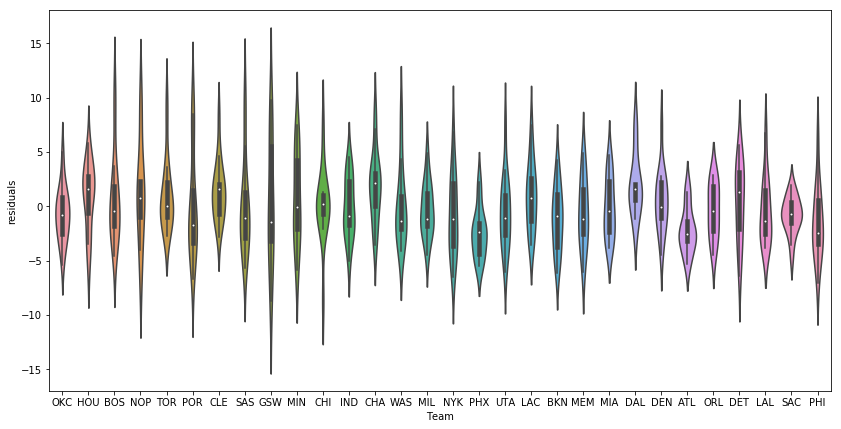

In [157]:
regularStatsWithTeam['residuals'] = regularStatsWithTeam['PTS'] - regularStatsReg.predict(regularStatsWithTeam[['REB', 'AST', 'STL', 'BLK', 'TOV']])
violin = sns.violinplot(x="Team", y="residuals", data=regularStatsWithTeam)

In [169]:
allStats = regularStatsWithTeam.merge(hustleStats[['Player', 'year', 'HustleScore']], on=['Player', 'year'])
allStats = allStats.dropna()
allStats.head()

,Player,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,...,REB,AST,STL,BLK,TOV,EFF,year,Team,residuals,HustleScore
0,Russell Westbrook,31.6,10.2,24.0,42.5,2.5,7.2,34.3,8.8,10.4,...,10.7,10.4,1.6,0.4,5.4,33.8,2016-17,OKC,-2.532363,1.525014
1,James Harden,29.1,8.3,18.9,44.0,3.2,9.3,34.7,9.2,10.9,...,8.1,11.2,1.5,0.5,5.7,32.4,2016-17,HOU,-5.851680,1.671438
2,Isaiah Thomas,28.9,9.0,19.4,46.3,3.2,8.5,37.9,7.8,8.5,...,2.7,5.9,0.9,0.2,2.8,24.7,2016-17,BOS,10.882764,1.241806
3,Anthony Davis,28.0,10.3,20.3,50.5,0.5,1.8,29.9,6.9,8.6,...,11.8,2.1,1.3,2.2,2.4,31.1,2016-17,NOP,8.400765,2.212520
4,DeMar DeRozan,27.3,9.7,20.9,46.7,0.4,1.7,26.6,7.4,8.7,...,5.2,3.9,1.1,0.2,2.4,22.7,2016-17,TOR,10.031919,1.232275


In [159]:
hustleRegularStatsReg = LinearRegression()
hustleRegularStatsReg.fit(allStats[['REB', 'AST', 'STL', 'BLK', 'TOV', 'HustleScore']], allStats['PTS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


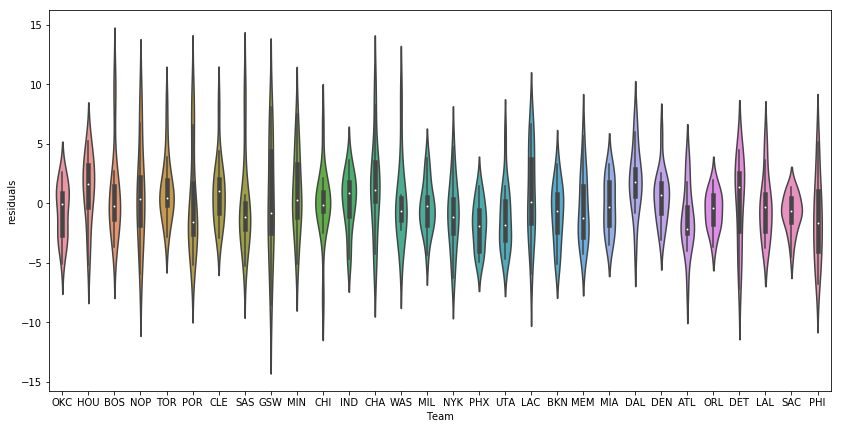

In [160]:
allStats['residuals'] = allStats['PTS'] - hustleRegularStatsReg.predict(allStats[['REB', 'AST', 'STL', 'BLK', 'TOV', 'HustleScore']])
violin = sns.violinplot(x="Team", y="residuals", data=allStats)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(allStats[['REB', 'AST', 'STL', 'BLK', 'TOV']], allStats['PTS'], test_size=0.1, random_state=0)

In [164]:
cross_val_score(regularStatsReg, X_test, y_test, cv=10).mean()

-0.37815552467247626

In [170]:
X_train, X_test, y_train, y_test = train_test_split(allStats[['REB', 'AST', 'STL', 'BLK', 'TOV', 'HustleScore']], allStats['PTS'], test_size=0.1, random_state=0)

In [171]:
cross_val_score(hustleRegularStatsReg, X_test, y_test, cv=10).mean()

-0.05443894921207308

In [167]:
hustleReg = LinearRegression()
hustleReg.fit(allStats[['HustleScore']], allStats['PTS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


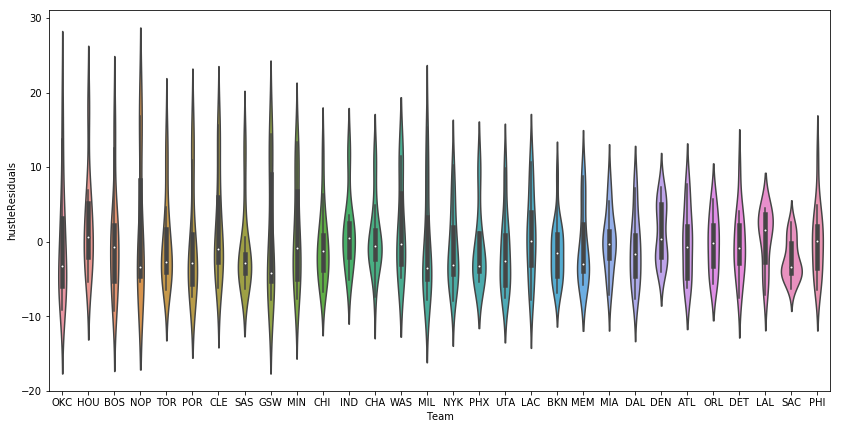

In [168]:
allStats['hustleResiduals'] = allStats['PTS'] - hustleReg.predict(allStats[['HustleScore']])
violin = sns.violinplot(x="Team", y="hustleResiduals", data=allStats)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(allStats[['HustleScore']], allStats['PTS'], test_size=0.1, random_state=0)
cross_val_score(hustleReg, X_test, y_test, cv=10).mean()

-1.6042020175202478